<a href="https://colab.research.google.com/github/RAAHUL-tech/LLM_Research/blob/main/Green_LLM_Energy%E2%80%91Aware_Model_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-393dad32-f2f5-665c-9fe6-ba8900e62564)


In [ ]:
%%capture
!pip install -U "transformers" "datasets" "accelerate" "evaluate" "bitsandbytes" "psutil" "torch" "scipy"

In [ ]:
import os, math, time, json, subprocess, threading, queue, random
from dataclasses import dataclass
from typing import List, Dict, Any, Optional
import numpy as np
import torch
from torch import nn
from torch.nn.utils import prune
from datasets import load_dataset
from transformers import (
AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling,
Trainer, TrainingArguments, set_seed, BitsAndBytesConfig
)
import evaluate
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
OUT_DIR = "/content/green_llm_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


set_seed(42)
random.seed(42)
np.random.seed(42)

Device: cuda


In [ ]:
class PowerSampler:
    def __init__(self, interval_sec: float = 0.25):
        self.interval = interval_sec
        self.samples = []  # (timestamp, watts)
        self._q = queue.Queue()
        self._stop = threading.Event()
        self._thread = threading.Thread(target=self._run, daemon=True)

    def _read_power(self) -> Optional[float]:
        try:
            out = subprocess.check_output([
                "nvidia-smi",
                "--query-gpu=power.draw",
                "--format=csv,noheader,nounits"
            ], stderr=subprocess.DEVNULL)
            val = float(out.decode("utf-8").strip().split("\n")[0])
            return val
        except Exception:
            return None

    def _run(self):
        while not self._stop.is_set():
            w = self._read_power()
            t = time.time()
            if w is not None:
                self.samples.append((t, w))
            time.sleep(self.interval)

    def start(self):
        self.samples.clear()
        self._stop.clear()
        self._thread = threading.Thread(target=self._run, daemon=True)
        self._thread.start()

    def stop(self):
        self._stop.set()
        self._thread.join()

    def energy_joules(self) -> float:
        if len(self.samples) < 2:
            return 0.0
        energy = 0.0
        for (t0, w0), (t1, w1) in zip(self.samples[:-1], self.samples[1:]):
            dt = t1 - t0
            w_avg = 0.5 * (w0 + w1)
            energy += w_avg * dt
        return energy

In [ ]:
DATASET_NAME = "roneneldan/TinyStories"
TOKENIZER_NAME = "openai-community/gpt2"
TRAIN_SAMPLES = 10_000
EVAL_SAMPLES = 4_000

raw = load_dataset(DATASET_NAME)
print(raw)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})


In [ ]:
train_texts = raw["train"]["text"][:5000]
val_texts = raw["validation"]["text"][:500]

# Tokenizer
tok = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
if tok.pad_token is None:
   tok.pad_token = tok.eos_token

# Tokenize and group into blocks

BLOCK_SIZE = 256

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=BLOCK_SIZE)

# Apply to datasets instead of just a Python list
train_tok = [tok(t, truncation=True, max_length=BLOCK_SIZE) for t in train_texts]
val_tok   = [tok(t, truncation=True, max_length=BLOCK_SIZE) for t in val_texts]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
def build_block_dataset(tok_list, block_size, max_blocks):
    ids = []
    for ex in tok_list:
        ids.extend(ex["input_ids"])
    # trim to multiple of block_size
    total = (len(ids) // block_size) * block_size
    ids = ids[:total]
    # make blocks
    input_ids = []
    for i in range(0, len(ids), block_size):
        input_ids.append(ids[i:i+block_size])
    if max_blocks is not None:
        input_ids = input_ids[:max_blocks]
    attn = [[1]*block_size for _ in input_ids]
    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attn, dtype=torch.long)
    }

train_blocks = build_block_dataset(train_tok, BLOCK_SIZE, TRAIN_SAMPLES//BLOCK_SIZE)
val_blocks = build_block_dataset(val_tok, BLOCK_SIZE, EVAL_SAMPLES//BLOCK_SIZE)

print("Train blocks:", len(train_blocks["input_ids"]))
print("Val blocks:", len(val_blocks["input_ids"]))

Train blocks: 39
Val blocks: 15


In [ ]:
class TorchLMDataset(torch.utils.data.Dataset):
    def __init__(self, blocks):
        self.input_ids = blocks["input_ids"]
        self.attn = blocks["attention_mask"]
    def __len__(self):
        return self.input_ids.shape[0]
    def __getitem__(self, idx):
        x = self.input_ids[idx]
        y = x.clone()
        return {
            "input_ids": x,
            "attention_mask": self.attn[idx],
            "labels": y,
        }

train_ds = TorchLMDataset(train_blocks)
val_ds = TorchLMDataset(val_blocks)

In [ ]:
# Teacher: `gpt2` (fp16)
# Student: `sshleifer/tiny-gpt2` (very small, fast to fine‑tune)

#TEACHER_NAME = "sshleifer/tiny-gpt2"
#STUDENT_NAME = "roneneldan/TinyStories-1M"

TEACHER_NAME = "openai-community/gpt2-medium"
STUDENT_NAME = "openai-community/gpt2"


teacher = AutoModelForCausalLM.from_pretrained(TEACHER_NAME).to(DEVICE)
teacher.eval()

student = AutoModelForCausalLM.from_pretrained(STUDENT_NAME)
student.resize_token_embeddings(len(tok))
student = student.to(DEVICE)

# Enable bf16/fp16 if supported
if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8:
    torch.set_float32_matmul_precision('high')

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# KL(student||teacher) on logits + CE to labels. Weight with alpha.
@dataclass
class KDConfig:
    temperature: float = 2.0
    alpha_kl: float = 0.5  # weight for KL; (1-alpha_kl) for CE

kd_cfg = KDConfig()

class DistillTrainer(Trainer):
    def __init__(self, teacher_model: nn.Module, kd_cfg: KDConfig, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.teacher.eval()
        for p in self.teacher.parameters():
            p.requires_grad_(False)
        self.kd = kd_cfg
        self.kl = nn.KLDivLoss(reduction="batchmean")

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs_s = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits_s = outputs_s.logits

        # Teacher forward
        with torch.no_grad():
            outputs_t = self.teacher(**{k: v for k, v in inputs.items() if k != "labels"})
            logits_t = outputs_t.logits

        # Shift for causal LM (ignore last token pred)
        shift_logits_s = logits_s[:, :-1, :].contiguous()
        shift_logits_t = logits_t[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        # CE loss (student vs ground truth)
        ce_loss = nn.functional.cross_entropy(
            shift_logits_s.view(-1, shift_logits_s.size(-1)),
            shift_labels.view(-1),
            ignore_index=-100
        )

        # KL loss (student vs teacher)
        T = self.kd.temperature
        log_prob_s = nn.functional.log_softmax(shift_logits_s / T, dim=-1)
        prob_t = nn.functional.softmax(shift_logits_t / T, dim=-1)
        kl_loss = self.kl(log_prob_s, prob_t) * (T * T)

        # Final loss: weighted sum
        loss = self.kd.alpha_kl * kl_loss + (1 - self.kd.alpha_kl) * ce_loss

        return (loss, outputs_s) if return_outputs else loss

In [ ]:
# Train the student with distillation (quick, few steps)
BATCH_SIZE = 2
GRAD_ACCUM = 4
EPOCHS = 100
LR = 5e-4
WARMUP = 50
student.gradient_checkpointing_enable()

args = TrainingArguments(
    output_dir=f"{OUT_DIR}/student_kd",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,
    fp16=torch.cuda.is_available(),
    bf16=False,
    learning_rate=LR,
    warmup_steps=WARMUP,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    report_to=[]
)

trainer = DistillTrainer(
    teacher_model=teacher,
    kd_cfg=kd_cfg,
    model=student,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    data_collator=DataCollatorForLanguageModeling(tok, mlm=False)
)

trainer.train()

# Save student
student.save_pretrained(f"{OUT_DIR}/student_kd_ckpt")
tok.save_pretrained(f"{OUT_DIR}/student_kd_ckpt")

/tmp/ipython-input-1889223224.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,85.205734
2,No log,108.747101
3,No log,76.141014
4,No log,72.618607
5,No log,69.538582
6,No log,66.677460
7,No log,66.665298
8,No log,63.873436
9,No log,65.554749
10,337.170000,63.517479


('/content/green_llm_outputs/student_kd_ckpt/tokenizer_config.json',
 '/content/green_llm_outputs/student_kd_ckpt/special_tokens_map.json',
 '/content/green_llm_outputs/student_kd_ckpt/vocab.json',
 '/content/green_llm_outputs/student_kd_ckpt/merges.txt',
 '/content/green_llm_outputs/student_kd_ckpt/added_tokens.json',
 '/content/green_llm_outputs/student_kd_ckpt/tokenizer.json')

In [ ]:
# Evaluation helpers (loss, perplexity, tokens/s, energy/token)

@torch.no_grad()
def eval_perplexity(model: nn.Module, dataset: TorchLMDataset, batch_size=16) -> float:
    model.eval()
    dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    losses, n_tokens = [], 0
    for batch in dl:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = model(**batch)
        # sum over tokens (not batch avg)
        loss_sum = out.loss * batch["labels"].numel()
        losses.append(loss_sum.detach().float().item())
        n_tokens += batch["labels"].numel()
    mean_loss = sum(losses) / n_tokens
    return math.exp(mean_loss)


@torch.no_grad()
def eval_throughput_energy(model: nn.Module, dataset: TorchLMDataset, batch_size=16, power_interval=0.0001):
    model.eval()
    dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    tokens_total = 0
    start = time.time()
    ps = PowerSampler(interval_sec=power_interval)
    ps.start()
    for batch in dl:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = model(**batch)
        # tokens: predicted next tokens equals labels count (non-padding)
        tokens_total += batch["labels"].numel()
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    ps.stop()
    end = time.time()
    elapsed = end - start
    energy_J = ps.energy_joules()
    tok_per_s = tokens_total / elapsed if elapsed > 0 else float('nan')
    J_per_token = energy_J / tokens_total if tokens_total > 0 else float('nan')
    return {
        "tokens": tokens_total,
        "seconds": elapsed,
        "throughput_tok_s": tok_per_s,
        "energy_J": energy_J,
        "energy_per_token_J": J_per_token,
    }

In [ ]:
# Baselines & compressed variants
# We will evaluate:
# - Teacher FP16 (no training)
# - Student after KD
# - Student + pruning at 30% and 60% sparsity (fine‑tune quick)
# - Quantized (8‑bit) teacher & student (inference only)

results = []

def log_result(name: str, cfg: Dict[str,Any], ppl: float, perf: Dict[str,Any]):
    row = {
        "method": name,
        "ppl": ppl,
        **perf,
        "config": json.dumps(cfg)
    }
    print(row)
    results.append(row)

# Teacher FP16 (move to half if GPU supports)
teacher_fp16 = AutoModelForCausalLM.from_pretrained(TEACHER_NAME, torch_dtype=torch.float16 if torch.cuda.is_available() else None)
teacher_fp16 = teacher_fp16.to(DEVICE).eval()

ppl = eval_perplexity(teacher_fp16, val_ds, batch_size=16)
perf = eval_throughput_energy(teacher_fp16, val_ds, batch_size=16)
log_result("Teacher FP16", {"model": TEACHER_NAME}, ppl, perf)

# Student KD (fp16 if possible)
student_eval = AutoModelForCausalLM.from_pretrained(f"{OUT_DIR}/student_kd_ckpt", torch_dtype=torch.float16 if torch.cuda.is_available() else None)
student_eval = student_eval.to(DEVICE).eval()

ppl = eval_perplexity(student_eval, val_ds, batch_size=32)
perf = eval_throughput_energy(student_eval, val_ds, batch_size=32)
log_result("Student KD", {"model": STUDENT_NAME, "kd": True}, ppl, perf)

`torch_dtype` is deprecated! Use `dtype` instead!
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


{'method': 'Teacher FP16', 'ppl': 9.38426664266175, 'tokens': 3840, 'seconds': 0.2837393283843994, 'throughput_tok_s': 13533.548633757644, 'energy_J': 12.981762268543244, 'energy_per_token_J': 0.0033806672574331364, 'config': '{"model": "openai-community/gpt2-medium"}'}
{'method': 'Student KD', 'ppl': 11.135700962413912, 'tokens': 3840, 'seconds': 0.12660908699035645, 'throughput_tok_s': 30329.576583175938, 'energy_J': 5.391851301193237, 'energy_per_token_J': 0.0014041279430190721, 'config': '{"model": "openai-community/gpt2", "kd": true}'}


In [ ]:
import torch, gc

# If you already have references in memory
#del teacher
#del student

# Run garbage collection and clear CUDA cache
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Unstructured and Structured Pruning
# Unstructured global magnitude pruning
# Structured pruning**: remove entire neurons (channels) in attention/MLP linear layers.

LINEAR_TYPES = (nn.Linear,)

def apply_global_pruning(model: nn.Module, amount: float):
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, LINEAR_TYPES):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)

@torch.no_grad()
def remove_pruning_reparam(model: nn.Module):
    for module in model.modules():
        if isinstance(module, LINEAR_TYPES) and hasattr(module, 'weight_mask'):
            prune.remove(module, 'weight')


def apply_structured_pruning(model: nn.Module, amount: float):
    for module in model.modules():
        if isinstance(module, LINEAR_TYPES):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)

# quick light FT after pruning to recover a bit

def quick_ft(model, train_ds, steps=400, lr=3e-4, batch_size=8):
    model.train()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    it = iter(dl)
    for s in range(steps):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(dl)
            batch = next(it)
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = model(**batch)
        out.loss.backward()
        optim.step(); optim.zero_grad(set_to_none=True)
    model.eval()

# Evaluate both unstructured and structured
for pruning_type, func in [("Unstructured", apply_global_pruning), ("Structured", apply_structured_pruning)]:
    for sparsity in [0.3, 0.6]:
        m = AutoModelForCausalLM.from_pretrained(f"{OUT_DIR}/student_kd_ckpt", torch_dtype=torch.float32 if torch.cuda.is_available() else None).to(DEVICE)
        func(m, amount=sparsity)
        quick_ft(m, train_ds, steps=400 if sparsity>0.5 else 200, lr=3e-4, batch_size=8)
        remove_pruning_reparam(m)
        ppl = eval_perplexity(m, val_ds, batch_size=32)
        perf = eval_throughput_energy(m, val_ds, batch_size=32)
        log_result(f"Student KD + {pruning_type} Prune {int(sparsity*100)}%", {"sparsity": sparsity, "type": pruning_type}, ppl, perf)
        # save
        save_dir = f"{OUT_DIR}/student_{pruning_type.lower()}_{int(sparsity*100)}"
        os.makedirs(save_dir, exist_ok=True)
        m.save_pretrained(save_dir)


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 84.12 MiB is free. Process 3116 has 14.66 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 188.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Quantization (8‑bit) for inference with bitsandbytes
# Loads linear layers in 8‑bit; evaluation only.

bnb_cfg = BitsAndBytesConfig(load_in_8bit=True)

# Teacher 8‑bit
teacher_8 = AutoModelForCausalLM.from_pretrained(TEACHER_NAME, quantization_config=bnb_cfg, device_map="auto")
# tokenizers are same
ppl = eval_perplexity(teacher_8, val_ds, batch_size=16)
perf = eval_throughput_energy(teacher_8, val_ds, batch_size=16)
log_result("Teacher 8-bit", {"bnb": "8bit"}, ppl, perf)

# Student 8‑bit
student_8 = AutoModelForCausalLM.from_pretrained(f"{OUT_DIR}/student_kd_ckpt", quantization_config=bnb_cfg, device_map="auto")
ppl = eval_perplexity(student_8, val_ds, batch_size=32)
perf = eval_throughput_energy(student_8, val_ds, batch_size=32)
log_result("Student KD 8-bit", {"bnb": "8bit"}, ppl, perf)

{'method': 'Teacher 8-bit', 'ppl': 9.426838597959112, 'tokens': 3840, 'seconds': 0.33475613594055176, 'throughput_tok_s': 11471.036936218947, 'energy_J': 20.886595599651336, 'energy_per_token_J': 0.005439217604075869, 'config': '{"bnb": "8bit"}'}
{'method': 'Student KD 8-bit', 'ppl': 35406.081399914336, 'tokens': 3840, 'seconds': 0.0651085376739502, 'throughput_tok_s': 58978.44026585129, 'energy_J': 2.3733458995819094, 'energy_per_token_J': 0.0006180588280161222, 'config': '{"bnb": "8bit"}'}


In [ ]:
# Results table, Pareto frontier & plots

df = pd.DataFrame(results)
df.to_csv(f"{OUT_DIR}/results.csv", index=False)
print(df)

                                method           ppl  tokens   seconds  \
0                         Teacher FP16      9.384267    3840  0.240264   
1                           Student KD  35406.081400    3840  0.042347   
2  Student KD + Unstructured Prune 30%  29984.231943    3840  0.025326   
3  Student KD + Unstructured Prune 60%  32058.915779    3840  0.025552   
4    Student KD + Structured Prune 30%  30258.097826    3840  0.027258   
5    Student KD + Structured Prune 60%  33078.021869    3840  0.024907   
6                        Teacher 8-bit      9.426839    3840  0.334756   
7                     Student KD 8-bit  35406.081400    3840  0.065109   

   throughput_tok_s   energy_J  energy_per_token_J  \
0      15982.423403  14.868705            0.003872   
1      90678.974197   1.229924            0.000320   
2     151619.902285   0.000000            0.000000   
3     150282.978390   0.000000            0.000000   
4     140877.722323   0.000000            0.000000   
5     154

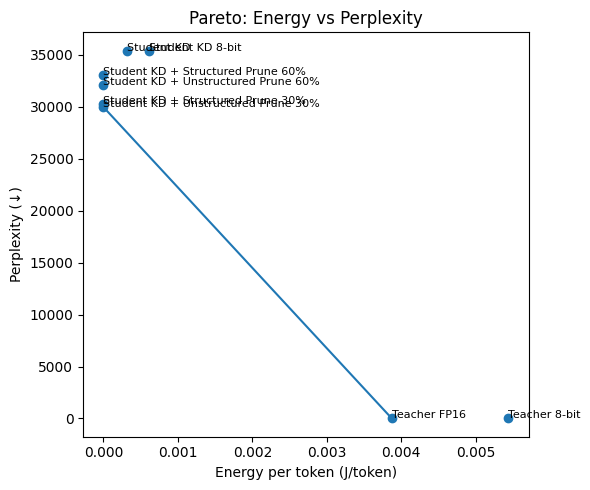

In [ ]:
# Pareto frontier (minimize energy_per_token_J and ppl)
def pareto_frontier(df: pd.DataFrame, x_col: str, y_col: str):
    pts = df[[x_col, y_col, 'method']].dropna().values
    pts = pts[pts[:,0].argsort()]  # sort by x
    pareto = []
    best_y = float('inf')
    for x, y, m in pts:
        if y <= best_y:
            pareto.append((x,y,m))
            best_y = y
    return np.array(pareto, dtype=object)

front = pareto_frontier(df, 'energy_per_token_J', 'ppl')

plt.figure(figsize=(6,5))
plt.scatter(df['energy_per_token_J'], df['ppl'])
for _, row in df.iterrows():
    plt.annotate(row['method'], (row['energy_per_token_J'], row['ppl']), fontsize=8)
if len(front)>0:
    plt.plot(front[:,0].astype(float), front[:,1].astype(float))
plt.xlabel('Energy per token (J/token)')
plt.ylabel('Perplexity (↓)')
plt.title('Pareto: Energy vs Perplexity')
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/pareto_energy_perplexity.png", dpi=180)
plt.show()

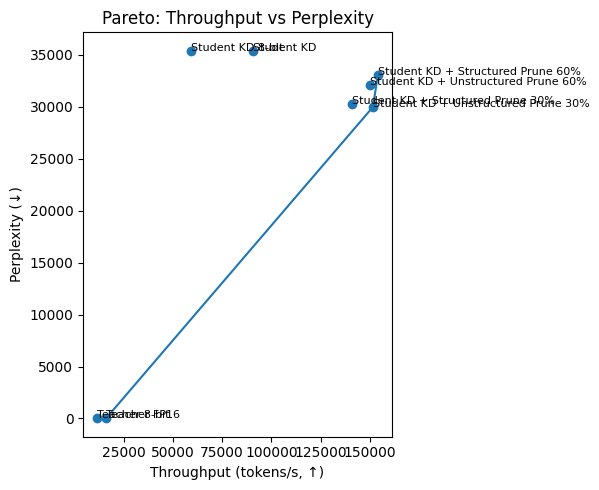

In [ ]:
# Throughput frontier (maximize throughput, minimize ppl) -> use -throughput as x for minimization
front_tp = pareto_frontier(df.assign(x=-df['throughput_tok_s']), 'x', 'ppl')
plt.figure(figsize=(6,5))
plt.scatter(df['throughput_tok_s'], df['ppl'])
for _, row in df.iterrows():
    plt.annotate(row['method'], (row['throughput_tok_s'], row['ppl']), fontsize=8)
if len(front_tp)>0:
    xs = -front_tp[:,0].astype(float)
    ys = front_tp[:,1].astype(float)
    plt.plot(xs, ys)
plt.xlabel('Throughput (tokens/s, ↑)')
plt.ylabel('Perplexity (↓)')
plt.title('Pareto: Throughput vs Perplexity')
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/pareto_energy_throughput.png", dpi=180)
plt.show()